In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

For more information about model comparison and model averaging check the PyMC3 documentation, specially:

* http://docs.pymc.io/notebooks/model_comparison.html
* http://docs.pymc.io/notebooks/model_averaging.html
* http://docs.pymc.io/notebooks/Bayes_factor.html

# Overfitting vs underfitting

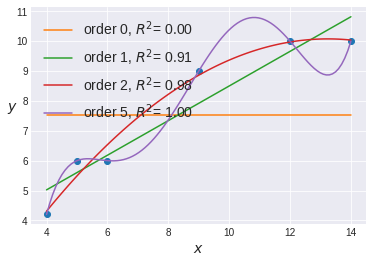

In [2]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2, fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)
plt.savefig('B04958_06_01.png', dpi=300, figsize=[5.5, 5.5])
#plt.plot([10, 7], [9, 7], 's')
#plt.savefig('B04958_06_02.png', dpi=300, figsize=[5.5, 5.5])

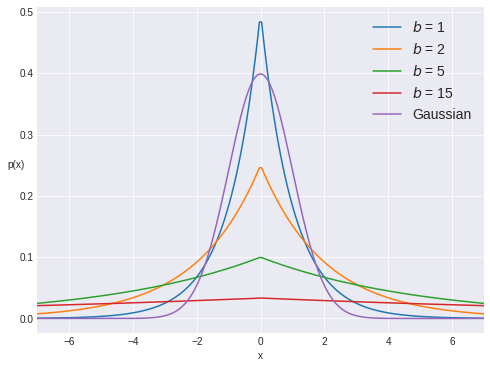

In [3]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.savefig('B04958_06_03.png', dpi=300, figsize=[5.5, 5.5])

In [4]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

In [5]:
np.random.seed(1)
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

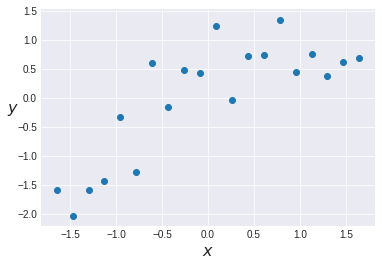

In [6]:
order = 2#5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_06_04.png', dpi=300, figsize=[5.5, 5.5])

In [7]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta * x_1s[0]
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_l = pm.sample(2100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 5200/5200 [00:02<00:00, 2359.42draws/s]


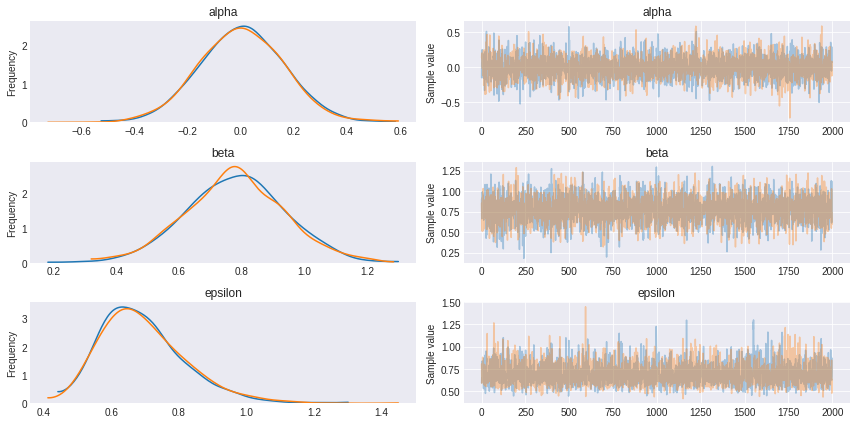

In [8]:
chain_l = trace_l[100:]
pm.traceplot(chain_l);

In [9]:
pm.summary(chain_l)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.001949,0.158910,0.002809,-0.321839,0.297166,3880.494111,0.999912
beta,0.778443,0.158030,0.002335,0.472297,1.093173,3997.847088,0.999781
epsilon,0.691424,0.123947,0.002224,0.477255,0.939624,3183.484553,1.000008


In [10]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])  
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, x_1s)
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_p = pm.sample(2100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 5200/5200 [00:04<00:00, 1138.89draws/s]


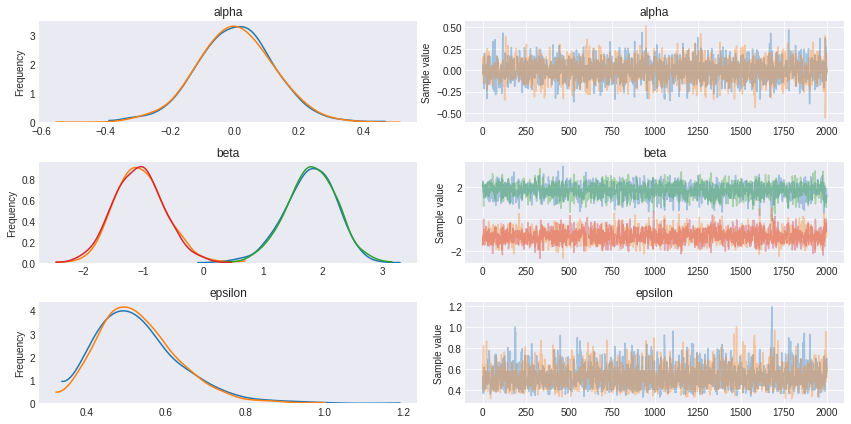

In [11]:
chain_p = trace_p[100:]
pm.traceplot(chain_p);

In [12]:
pm.summary(chain_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.000773,0.120206,0.002349,-0.240435,0.236768,2504.544903,0.999847
beta__0,1.796662,0.423802,0.010746,0.974254,2.623599,1458.257750,1.001142
beta__1,-1.067555,0.423419,0.010794,-1.843283,-0.201325,1484.021394,1.001270
epsilon,0.530270,0.103948,0.002025,0.358627,0.737277,1875.955485,0.999810


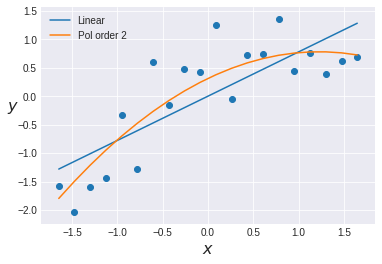

In [13]:
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')


alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend()
plt.savefig('B04958_06_05.png', dpi=300, figsize=[5.5, 5.5])

# Information criteria

In [14]:
# dic has been removed from PyMC3 

In [15]:
waic_l = pm.waic(trace=trace_l, model=model_l)
waic_l

WAIC_r(WAIC=42.81982702862565, WAIC_se=4.066937776755636, p_WAIC=2.2204204090929593, var_warn=0)

In [16]:
waic_p = pm.waic(trace=trace_p, model=model_p)
waic_p

WAIC_r(WAIC=32.71032421770529, WAIC_se=4.542578087022141, p_WAIC=2.6563472428546953, var_warn=0)

In [17]:
loo_l = pm.loo(trace=trace_l, model=model_l)
loo_l

LOO_r(LOO=42.923305898110165, LOO_se=4.09316133520336, p_LOO=2.2721598438352117, shape_warn=0)

In [18]:
loo_p = pm.loo(trace=trace_p, model=model_p)
loo_p

LOO_r(LOO=32.88379277800457, LOO_se=4.575110397075372, p_LOO=2.7430815230043404, shape_warn=0)

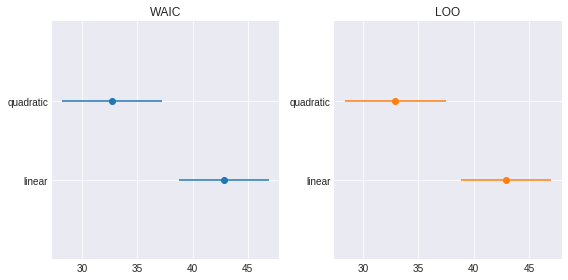

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='C0o')
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='C1o')
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.tight_layout()

plt.savefig('B04958_06_06.png', dpi=300, figsize=[5.5, 5.5])

## Posterior predictive checks

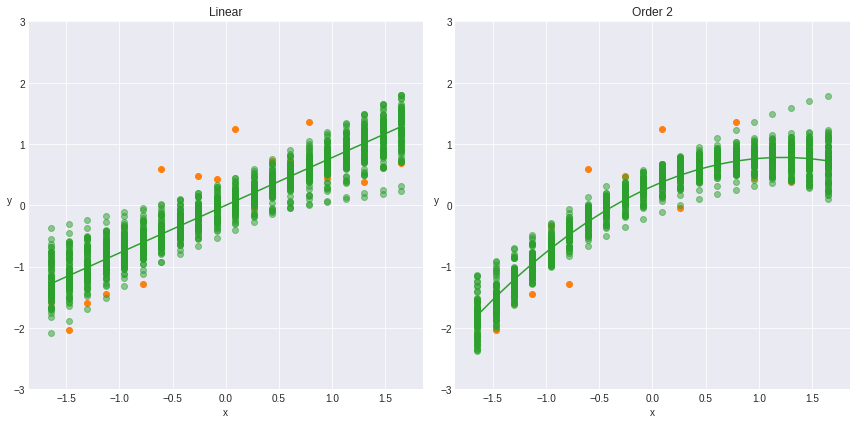

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='C1');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')


for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='C2',
                edgecolors='C2', alpha=0.5);
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean()*x_1s[0], c='C2', alpha=1)

    
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='C1');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))
for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='C2',
                edgecolors='C2', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post + np.dot(betas_p_post, x_1s)[idx], c='C2', alpha=1);

plt.tight_layout()
plt.savefig('B04958_06_07.png', dpi=300, figsize=[5.5, 5.5])

# Bayes factors

In [21]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

In [22]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y_d)
     
    trace_BF = pm.sample(5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [theta]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2731.28draws/s]


0.9183333333333333 0.08166666666666667 11.244897959183673


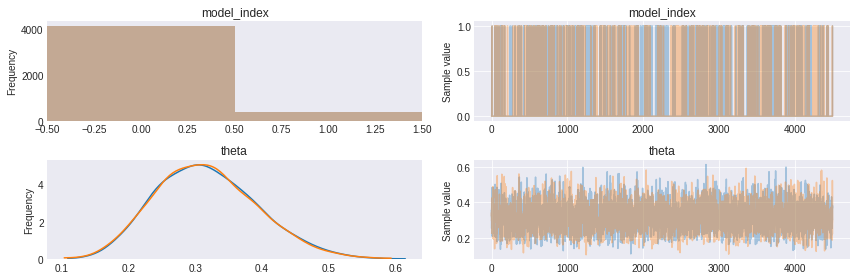

In [23]:
chain_BF = trace_BF[500:]
pm.traceplot(chain_BF)
pM1 = chain_BF['model_index'].mean()
pM0 = 1 - pM1
print(pM0, pM1, (pM0/pM1)*(p[1]/p[0]))
plt.savefig('B04958_06_09.png', dpi=300, figsize=[5.5, 5.5])

In [24]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    
    trace_BF_0 = pm.sample(5000)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:02<00:00, 3867.17draws/s]


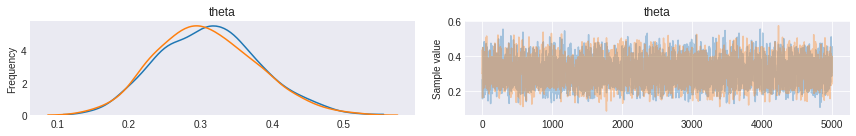

In [25]:
chain_BF_0 = trace_BF_0[500:]
pm.traceplot(trace_BF_0)
plt.savefig('B04958_06_10.png', dpi=300, figsize=[5.5, 5.5])

In [26]:
with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    
    trace_BF_1 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:02<00:00, 3981.12draws/s]


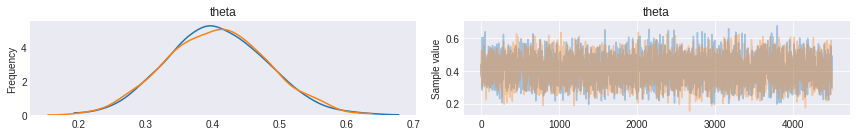

In [27]:
chain_BF_1 = trace_BF_1[500:]
pm.traceplot(chain_BF_1)
plt.savefig('B04958_06_11.png', dpi=300, figsize=[5.5, 5.5])

In [28]:
waic_0 = pm.waic(chain_BF_0, model_BF_0)
waic_0

WAIC_r(WAIC=38.09644202086107, WAIC_se=4.235558774584315, p_WAIC=0.7152017987902174, var_warn=0)

In [29]:
waic_1 = pm.waic(chain_BF_1, model_BF_1)
waic_1

WAIC_r(WAIC=39.484731710448, WAIC_se=1.992884901235452, p_WAIC=0.6815175275957985, var_warn=0)

In [30]:
loo_0 = pm.loo(chain_BF_0, model_BF_0)
loo_0

LOO_r(LOO=38.097804999714455, LOO_se=4.235899385037414, p_LOO=0.7158832882169115, shape_warn=0)

In [31]:
loo_1 = pm.loo(chain_BF_1, model_BF_1)
loo_1

LOO_r(LOO=39.48573564302184, LOO_se=1.9930308251030797, p_LOO=0.6820194938827164, shape_warn=0)

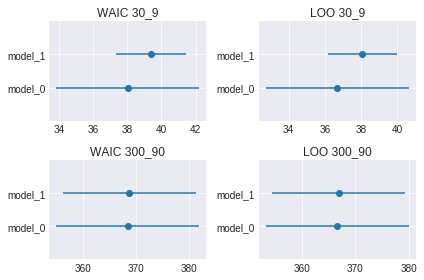

In [32]:
est = [((38.02, 4.17), (39.41, 2.04)), ((36.69, 3.96), (38.09, 1.94)),
       ((368.41, 13.40), (368.76, 12.48)) , ((366.61, 13.31), (366.87, 12.34))]

title = ['WAIC 30_9', 'LOO 30_9', 'WAIC 300_90', 'LOO 300_90']

for i in range(4):
    plt.subplot(2,2,i+1)
    for idx, ic in enumerate(est[i]):
        plt.errorbar(ic[0], idx, xerr=ic[1], fmt='C0o')
    plt.title(title[i])
    plt.yticks([0, 1], ['model_0', 'model_1'])
    plt.ylim(-1, 2)

plt.tight_layout()

plt.savefig('B04958_06_12.png', dpi=300, figsize=[5.5, 5.5])

In [33]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.6.6
IPython 6.5.0
PyMC3 3.5
NumPy 1.14.5
SciPy 1.1.0
Matplotlib 2.2.2

